# Hargraves Data Navigator

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = {'svg',}

In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import re
import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import pmagpy.pmagplotlib as pmagplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, widgets
import ipywidgets
from IPython.display import display, HTML
from hargraves_stream_utilities import *
import traitlets

/Users/lukefairchild765/anaconda/envs/python2/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2017-04-17 16:32:34.244997. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


Enter the relative path to your data within the **Hargraves_Data** Dropbox folder, or choose a recently opened directory.

In [3]:
warnings.filterwarnings('ignore', category=DeprecationWarning)
#default path for Hargraves_Data folder on this machine---this should not need to be changed
hargraves_path = '/Users/lukefairchild765/Dropbox/Hargraves_Data/'
# type the directory containing the site data
try:
    dirs_history = open('recent_parent_dirs.txt', 'r')
    recent_dirs_list = dirs_history.readlines()
    dirs_history.close()
    for d in range(len(recent_dirs_list)):
        recent_dirs_list[d] = recent_dirs_list[d].split()[0]
    recent_dirs_list.reverse()
    most_recent_site = recent_dirs_list[0]
#     recent_dirs_list[-1].split()[0]
except:
    dirs_history = open('recent_parent_dirs.txt', 'w')
    recent_dirs_list = []
    dirs_history.close()
    recent_dirs_list.reverse()
cd_dir_list = []
site_dir_select = widgets.Text(placeholder='Type path to site folder within Hargraves_Data')
indicator = widgets.Button(description='Input',disabled=False,button_style='info',tooltip='Click me',icon='check')
# cd_dir_options = widgets.Select(options=[], width='auto')
cd_dir_options = widgets.Textarea(value='', disabled=True)
# cd_dir_options_widget.set_title(0,'ls')
# cd_dir_options_widget.visible = False
most_recent = widgets.Select(options=recent_dirs_list, width='auto')
most_recent_list_widget = widgets.Accordion(children=[most_recent])
most_recent_list_widget.set_title(0, 'Recent directories:')
box = widgets.HBox(children=[widgets.VBox(children=[indicator, site_dir_select, cd_dir_options]), most_recent_list_widget], display='flex')
# box = widgets.Accordion(children=[site_dir_select, indicator,most_recent])
# display(site_dir_select)
# display(indicator)
# display(most_recent)
display(box)

# dl = traitlets.dlink((most_recent, 'value'), (site_dir_select, 'value'))

def use_recent(sender):
    with most_recent.hold_trait_notifications():
        site_dir_select.value = most_recent.value
    return site_dir_select.send_state()
#     return most_recent.get_state()['value']
#     site_dir_select.set_state('value')
#     indicator.description = 'Data found!'
#     indicator.button_style = 'success'
most_recent.observe(use_recent)

def handle_submit(sender):
    global full_sam_path
    global recent_dirs_list
    global cd_dir_list
    full_sam_path = os.path.abspath(hargraves_path + '/' + site_dir_select.value)
    if os.path.exists(full_sam_path):# and '(*.sam$)' in map(str,os.listdir(full_input_path)):
        cd_dir_options.value = '\n'.join(os.listdir(full_sam_path))
        for j in map(str,os.listdir(full_sam_path)):
            if str(j).endswith('.sam'):
                indicator.description = 'Data found!'
                indicator.button_style = 'success'
                if (site_dir_select.value + '\n') not in recent_dirs_list and len(site_dir_select.value)!=0:
                    dirs_history = open('recent_parent_dirs.txt', 'a+')
                    dirs_history.write(site_dir_select.value + '\n')
                    dirs_history.close()
                    dirs_history = open('recent_parent_dirs.txt', 'r')
                    recent_dirs_list = dirs_history.readlines()
                    dirs_history.close()
                    for d in range(len(recent_dirs_list)):
                        recent_dirs_list[d] = recent_dirs_list[d].split()[0]
                    recent_dirs_list.reverse()
                return full_sam_path
        indicator.description = 'Not site level.'
        indicator.button_style = 'warning'
    elif not os.path.exists(full_sam_path):
        indicator.description = 'Check your input.'
        indicator.button_style = 'danger'
    return full_sam_path

# indicator.observe(handle_submit)
site_dir_select.observe(handle_submit)
most_recent.observe(handle_submit)
# site_dir_select.observe(use_recent)
# indicator.observe(use_recent)

site_dir_select.on_submit(handle_submit)

if site_dir_select.value=='':
    site_dir_select.value=most_recent_site
# site_dir_select.on_trait_change(handle_submit)

In [4]:
# def select_site_dir(append_path = ''):
#     if '*.sam' in os.listdir(hargraves_path+append_path):
#         return os.listdir(hargraves_path+append_path)
#     listed_dirs = os.listdir(hargraves_path+append_path)
#     filtered_dirs = []
#     for d in listed_dirs:
#         if str(d).startswith('.'):
#             pass
#         else:
#             filtered_dirs.append(d)
#     site_dir = widgets.Dropdown(options=filtered_dirs)
# #     display(site_dir)
#     site_dir.on_trait_change(select_site_dir(site_dir.get_state()['value']))
# select_site_dir()

In [5]:
# site_dir = widgets.Dropdown(options=os.listdir(hargraves_path))
# display(site_dir)
# site_dir.on_trait_change(print_something)

In [6]:
from IPython.display import Javascript, display
from ipywidgets import widgets

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Plot", button_style='info', 
                        icon='check', width = '75px', display='flex')
# button.layout.margin = '100px 150px 100px 80px;'
button.on_click(run_all)
display(button)

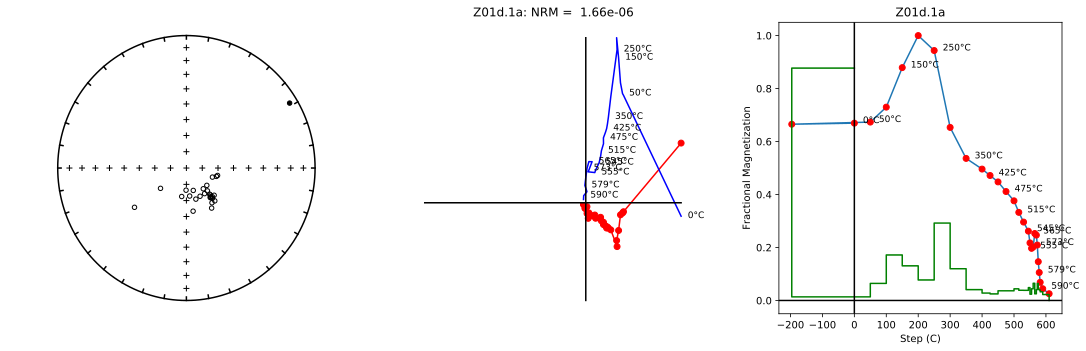

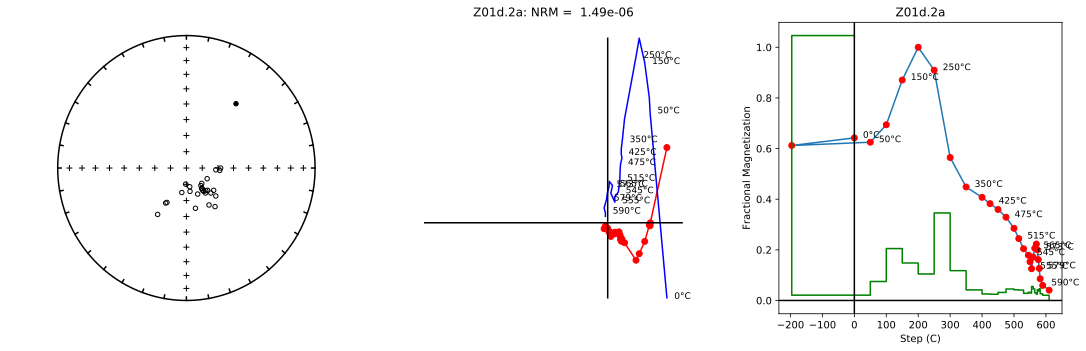

In [7]:
global hargraves_path
site_dir = site_dir_select.get_state()['value']
assert len(site_dir)!=0, "Data was not read. Check your input path."
def get_data(hargraves_path, dir_path = None, sample_number=1, data_level='sample'):
    global full_sam_path
    full_path = os.path.abspath(hargraves_path + '/' + dir_path)
    if full_sam_path!=os.path.abspath(full_path + '/' + os.path.basename(full_path) + '.sam'):
        full_sam_path = os.path.abspath(full_path + '/' + os.path.basename(full_path) + '.sam')
        er_specimens, er_sites, er_samples, magic_measurements = read_inp(None,full_sam_path)
        global er_specimens, er_sites, er_samples, magic_measurements
        
    else:
        try:
            global er_specimens, er_sites, er_samples, magic_measurements
        except:
            full_sam_path = os.path.abspath(full_path + '/' + os.path.basename(full_path) + '.sam')
            er_specimens, er_sites, er_samples, magic_measurements = read_inp(None,full_sam_path)
            global er_specimens, er_sites, er_samples, magic_measurements

    all_samp = er_samples.er_sample_name.unique().tolist()
    samp_list = []
    try:
        for s in all_samp:
            samp_list.append(s.split('.')[1])
        if '.' not in os.path.basename(full_path):
            sample_name = os.path.basename(full_path) + '.' + str(sample_number)
        else:
            sample_name = os.path.basename(full_path) + str(sample_number)
    except:
        for s in all_samp:
            samp_list.append(s.split('-')[1])
        if '-' not in os.path.basename(full_path):
            sample_name = os.path.basename(full_path) + '-' + str(sample_number)
        else:
            sample_name = os.path.basename(full_path) + str(sample_number)
            
    if data_level=='site':
        return samp_list

    specimen_name = sample_name + 'a'
    tr = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['treatment_temp'].tolist()
    dec = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_dec'].tolist()
    inc = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_inc'].tolist()
    moment = magic_measurements.ix[magic_measurements.er_specimen_name==specimen_name]['measurement_magn_moment'].tolist()

    datablock = map(list, zip(tr, dec, inc, moment))
    
    sample_info = er_samples.ix[er_samples['er_sample_name']==sample_name]
    sample_info.reset_index(inplace=True, drop=True)
    dec_geo, inc_geo = [], []
    dec_tc, inc_tc = [], []
    for n in range(len(dec)):
        d, i = pmag.dogeo(dec[n], inc[n], sample_info.sample_azimuth[0], sample_info.sample_dip[0])
        dec_geo.append(d)
        inc_geo.append(i)
    for n in range(len(dec_geo)):
        d, i = pmag.dotilt(dec_geo[n], inc_geo[n], sample_info.sample_bed_dip_direction[0], sample_info.sample_bed_dip[0])
        dec_tc.append(d)
        inc_tc.append(i)
    measurements = {'er_specimens':er_specimens, 'er_sites':er_sites, 
                    'er_samples':er_samples, 'magic_measurements':magic_measurements, 
                    'datablock':datablock, 'dec_geo':dec_geo, 'inc_geo':inc_geo, 
                    'dec_tc':dec_tc, 'inc_tc':inc_tc, 'samp_list':samp_list, 
                    'dec':dec, 'inc':inc, 'treatment':tr, 'moment':moment}
    return measurements

def plot_equal_area(sample_num=1,crd='Geographic'):
#     global hargraves_path, site_dir
    data = get_data(hargraves_path, dir_path=site_dir, sample_number=sample_num)
    magic_measurements = data['magic_measurements']
    er_samples = data['er_samples']
    er_sites = data['er_sites']
    er_specimens = data['er_specimens']
    dec = data['dec']
    inc = data['inc']
    dec_geo = data['dec_geo']
    inc_geo = data['inc_geo']
    dec_tc = data['dec_tc']
    inc_tc = data['inc_tc']
    tr = data['treatment']
    moment = data['moment']
    
    sample = str(sample_num)
    if '-' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'-'+sample
    elif '.' in str(magic_measurements['er_specimen_name'][0]):
        sample_name = magic_measurements.er_site_name.unique()[0]+'.'+sample
    specimen_name = sample_name + 'a'
    
    fig = plt.figure(figsize=(15,5))
    ax1 = plt.subplot2grid((1,3), (0,0), colspan=1)
    plt.axis("off")
    plot_net()

    if crd=='Core':
        datablock = map(list, zip(tr, dec, inc, moment))
        ipmag.plot_di(dec,inc)
    elif crd =='Geographic':
        datablock = map(list, zip(tr, dec_geo, inc_geo, moment))
        ipmag.plot_di(dec_geo, inc_geo)
    elif crd=='Tilt corrected':
        datablock = map(list, zip(tr, dec_tc, inc_tc, moment))
        ipmag.plot_di(dec_tc, inc_tc)
    else:
        return 'No coordinate system selected'
    ax1.axis('tight')

    ax2 = plt.subplot2grid((1,3), (0,1), colspan=1)
#     plt.axis("off")
    plotZ(datablock, 90, specimen_name, 0)
    ax2.axis('tight')

    ax3 = plt.subplot2grid((1,3), (0,2), colspan=1)
    plt.axis("on")
    plotMT(datablock,specimen_name, 1, 'K',1)
    ax3.axis('tight')
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1, wspace=0, hspace=0)
    fig.tight_layout()
    fig.show()
#     plt.show()
    
w = interact(plot_equal_area, sample_num=widgets.Select(options=get_data(hargraves_path, dir_path=site_dir, data_level='site')), crd=['Core', 'Geographic', 'Tilt corrected']);
w.widget.children[0].description='Sample'
w.widget.children[1].description=''
w.widget.children[1].layout = w.widget.children[0].layout

In [ ]:
magic_measurements.ix[0]